CPU run time: 47.82722473144531


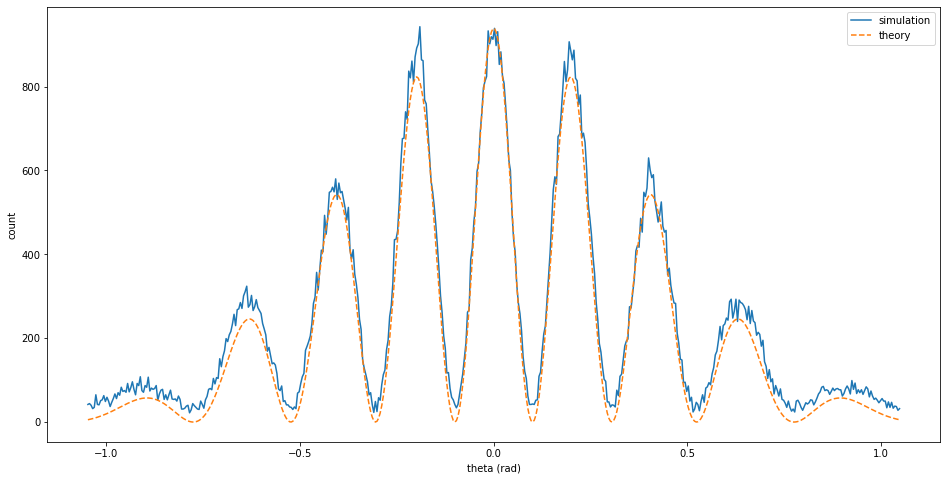

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time

"""some experiment parameters"""
pi = np.pi
lam = 6.7e-7  # photon wavelength = 670nm
d = 5 * lam   # slit separation
a = lam   # aperture of the source
X = 0.05
gamma = 0.999

def path(y0, beta, X):
    """
    calculate the phase shift of a single photon after //
    travelling from the source to the detector
    
    Params: 
        y0: the y coordinate of the position where the photon leaves the line source
        beta: the incident angle (randomly chosen between -alpha/2 and +alpha/2)
        X: the x coordinate of the detector array (the screen)
    
    return:
        theta: the (angular) index of the detector which is hit by the photon
        phi: the phase shift of the photon upon arrival at the detector
    """
    z = y0 / X
    assert abs(z) < 1.
    
    theta = np.arcsin(z * np.cos(beta)**2 + np.sin(beta) * np.sqrt(1 - (z * np.cos(beta))**2))
    
    s = X * np.sqrt(1 - 2 * z * np.sin(beta) + z**2)
    phi = 2 * pi * s / lam
    
    return theta, phi

def simulate(det, gamma, X, N):
    """
    Paras:
        det: a 2d array of shape (M, 2) storing the polorization vectors of all M detectors
        gamma: should be close to 1^-
        X: the radius of the screen
        N: total photon emissions
    return:
        count: array of shape (M) storing the photon detection counts of each detector
    """   
    count = np.zeros(len(det))
    
    for i in range(N):
        """simulate the source"""
        y0 = (2 * np.random.rand() - 1) * a / 2  # [-a/2, a/2]
        sign = np.random.rand()
        if sign > 0.5:
            y0 = y0 + d/2   # [(d-a)/2, (d+a)/2] from source S1
        else:
            y0 = y0 - d/2   # [(-d-a)/2, (-d+a)/2] from source S2
        beta = (2 * np.random.rand() - 1) * pi / 2   # beta in range [-pi/2, pi/2]
        
        theta, phi = path(y0, beta, X)
        
        e = np.array([np.cos(phi), np.sin(phi)])  # photon electric field polorization
        """simulate the detector"""
        dtheta = (pi/3) / M  #detection window of a single detector
        idx = int(theta//dtheta) + M
        if idx<0 or idx>2*M-1:  # discard photons out of detection range
            continue
        det[idx] = gamma * det[idx] + (1-gamma) * e
        """threshold function"""
        r = np.random.rand()
        threshold = det[idx] @ det[idx] - r
        
        if threshold > 0:
            count[idx] += 1
        
    return count

"""detectors deployed in the range of [-pi/3, pi/3]"""
M = 256
det = np.ones((2*M, 2)) / np.sqrt(2)

start = time.time()
# 1M samples
simulate(det, gamma, X, N=1000000)   # warm up the detectors
count = simulate(det, gamma, X, N =1000000)  # real simulation
print("CPU run time:", time.time()-start)


"""analytical result for comparison"""
def theory(theta):
    q = 2*pi / lam
    u = q * a * np.sin(theta) / 2
    v = q * d * np.sin(theta) / 2
    return (np.sin(u)/u)**2 * np.cos(v)**2

xaxis = np.linspace(-pi/3, pi/3, 2*M)

fig = plt.figure(figsize=(16, 8))
plt.plot(xaxis, count, label="simulation")
plt.plot(xaxis, count[M]*theory(xaxis), '--', label="theory")
plt.xlabel("theta (rad)")
plt.ylabel("count")
plt.legend()

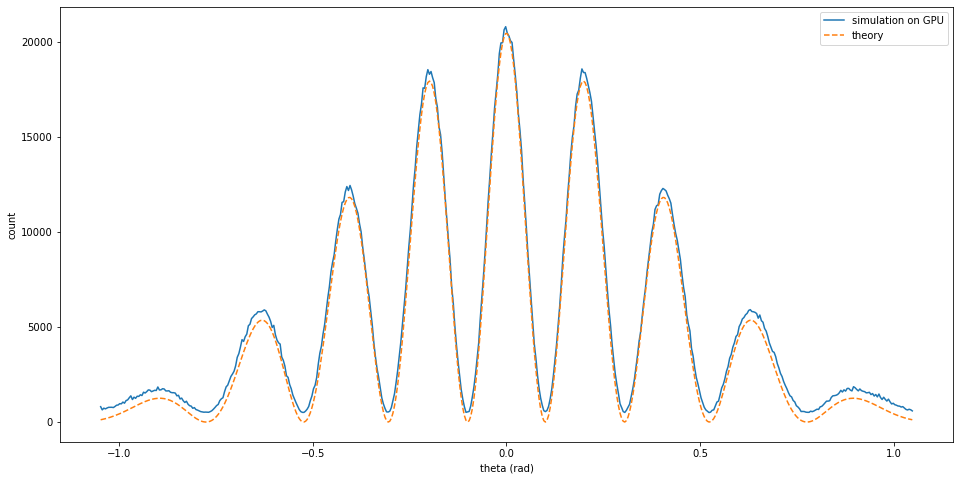

In [7]:
xaxis = np.linspace(-pi/3, pi/3, 2*M)

count_gpu = np.zeros(2*M)

with open('count.txt', 'r') as f:
    i=0
    for lines in f:
        data = lines.split()
        count_gpu[i] = int(data[0])
        i += 1
    
#print(count_gpu)

fig2 = plt.figure(figsize=(16, 8))
plt.plot(xaxis, count_gpu, label="simulation on GPU")
plt.plot(xaxis, count_gpu[M]*theory(xaxis), '--', label="theory")
plt.xlabel("theta (rad)")
plt.ylabel("count")
plt.legend()